# **Test modélisation LOF**

Hypothèse de départ : on dispose d'un dataset sans étiquette dont on sait qu'il y a 2.5% d'anomalies (expérience production). On dispose d'un 2ème dataset uniquement d'anomalies selon 7 classes.

Objectif : Créer un modèle de clustering capable de détecter ces anomalies  mais aussi des nouvelles et des dérives. 

### Chargement des librairies

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import umap
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, matthews_corrcoef, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, average_precision_score, precision_score,recall_score,f1_score,roc_curve
from sklearn.utils import shuffle
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors,LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope, MinCovDet

warnings.filterwarnings("ignore")
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chargement des data

In [6]:
# Chargement des datasets et concaténation dans un df
df_raw = pd.read_csv('/Users/matthieuclaudel/Desktop/MLE_Formation/MLOPS_project/INPUTS/DATASET_GO_NG.csv',sep=';',decimal=',',index_col="index", low_memory=False)
df_default = pd.read_csv('../data/raw/DATASET_NG.csv',sep=';',decimal=',',index_col="index", low_memory=False)

# Nettoyage
df_raw.target = df_raw.target.fillna(10000)
df_raw.target = df_raw.target.astype('float')
df_raw.target = df_raw.target.replace(14,1)
df_raw.target = df_raw.target.replace(13,1)
df_raw.target = df_raw.target.replace(20,1)
df_raw.target = df_raw.target.replace(9,1)
df_raw.target = df_raw.target.replace(111,1)
df_raw.target = df_raw.target.replace(5,1)
df_raw.target = df_raw.target.replace(207,1)
df_raw.target = df_raw.target.replace(27,1)
df_raw.target = df_raw.target.replace(121,1)

In [7]:
df_raw.target.value_counts(normalize=True)

target
0.0        0.502715
10000.0    0.474342
1.0        0.022943
Name: proportion, dtype: float64

### Preprocessing

In [8]:
# Séparation du df pour récupération échantillon target = 0
df_raw0 = df_raw[df_raw.target==0]
df_raw1 = df_raw[df_raw.target==1]
df_raw10000 = df_raw[df_raw.target==10000]

# Mélange et récupération d'un jeu de 400 échantillons conformes
df_raw0 = shuffle(df_raw0)
df_conf = df_raw0[0:399]

# Recomposition du dataset df_raw
df_raw = df_raw0[400:]
#df_raw = pd.concat([df_raw0[400:],df_raw1])
#df_raw = pd.concat([df_raw0[400:],df_raw1,df_raw10000])
df_raw = shuffle(df_raw)

# Recomposition du dataset de test
df_default.target = 1
df_validation = pd.concat([df_default,df_conf])
df_validation = shuffle(df_validation)
# Suppression des colonnes moyenne, écart-type, médiane, min et max
df_raw = df_raw.drop(['moyenne', 'ecartype', 'mediane', 'min', 'max'], axis=1)
df_validation = df_validation.drop(['moyenne', 'ecartype', 'mediane', 'min', 'max'], axis=1)

#Séparation features/target
X = df_raw.drop('target', axis=1)
y = df_raw.target
X_val = df_validation.drop('target', axis=1)
y_val = df_validation.target

# Normalisation/Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.fit_transform(X_val)

# Création de dataframe
df_scaled = pd.DataFrame(X_scaled, )
df_val_scaled = pd.DataFrame(X_val_scaled, )
df_scaled.columns = X.columns
df_val_scaled.columns = X.columns

# Séparation des données raw X_2d en train et test
#X_train, X_test,y_train,y_test = train_test_split(df_scaled,y,test_size=0.05, stratify=y)

In [9]:
df_raw.target.value_counts(normalize=True)

target
0.0    1.0
Name: proportion, dtype: float64

# MLFLOW tracking

In [10]:
import dagshub
dagshub.init(repo_owner='crotelius77', repo_name='MLOps_Detection_Anomalies_Acoustiques_Et_Vibratoires_Moteurs_Electriques', mlflow=True)
import mlflow
from mlflow import MlflowClient
client = MlflowClient(tracking_uri='https://dagshub.com/crotelius77/MLOps_Detection_Anomalies_Acoustiques_Et_Vibratoires_Moteurs_Electriques.mlflow')
matt_experiment = mlflow.set_experiment("matthieu_models")
mlflow.autolog(disable=True)


Accessing as crotelius77

Initialized MLflow to track repo 
"crotelius77/MLOps_Detection_Anomalies_Acoustiques_Et_Vibratoires_Moteurs_Electriques"

Repository crotelius77/MLOps_Detection_Anomalies_Acoustiques_Et_Vibratoires_Moteurs_Electriques initialized!

In [40]:
run_name = 'MC_LOF_run_novelty_09'
artifact_path = 'lof_matt'

In [41]:
params = {
    "novelty":True,
    "n_neighbors":15,
    "contamination":0.05,
    "metric":"cosine",
    "n_jobs":-1,
}

Nombre d'erreurs :  420 

Accuracy : 51.28 % 

Score ROC-AUC : 54.64 % 

Score MCC : 0.2127101575391762 

Rapport de classification : 
               precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       399
         1.0       1.00      0.09      0.17       463

    accuracy                           0.51       862
   macro avg       0.74      0.55      0.41       862
weighted avg       0.76      0.51      0.39       862
 

Matrice de confusion : 

Nombre d'erreurs :  346 

Accuracy : 59.86 % 

Score ROC-AUC : 62.63 % 

Score MCC : 0.3678838703234395 

Rapport de classification : 
               precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       399
         1.0       1.00      0.25      0.40       463

    accuracy                           0.60       862
   macro avg       0.77      0.63      0.55       862
weighted avg       0.79      0.60      0.54       862
 

Matrice de confusion : 

Nombre d'erreurs :  

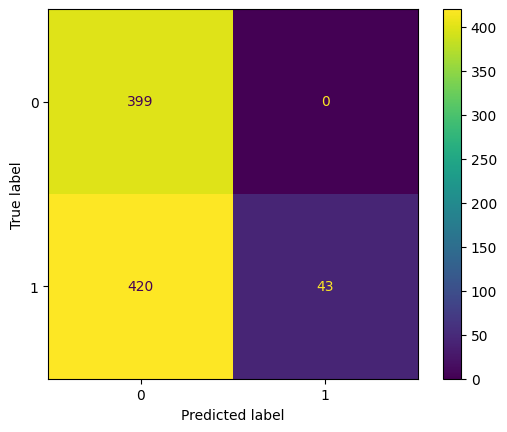

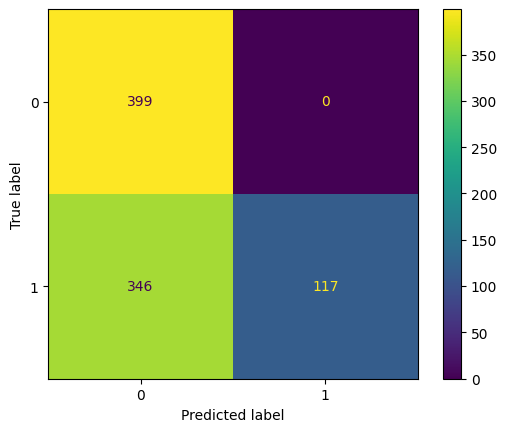

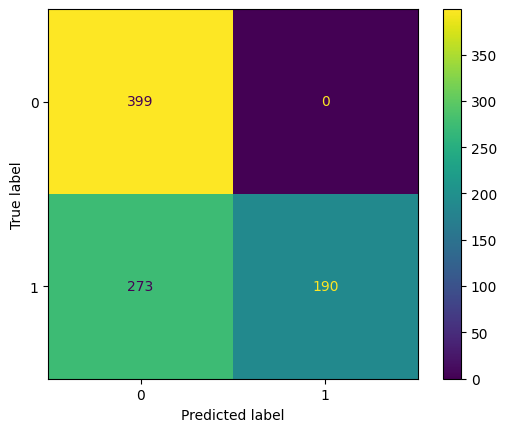

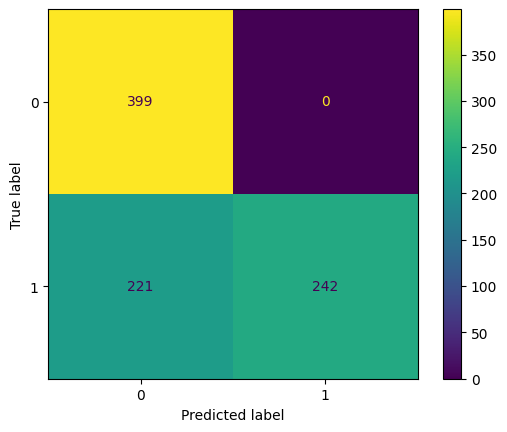

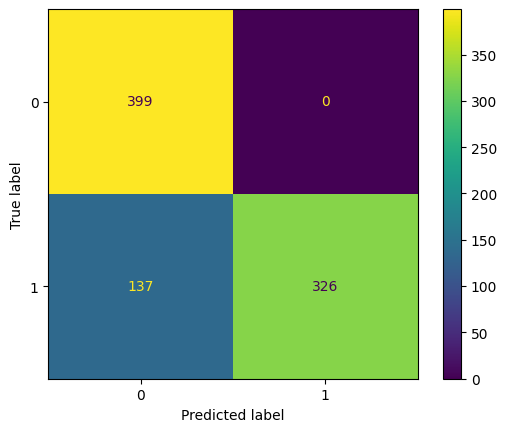

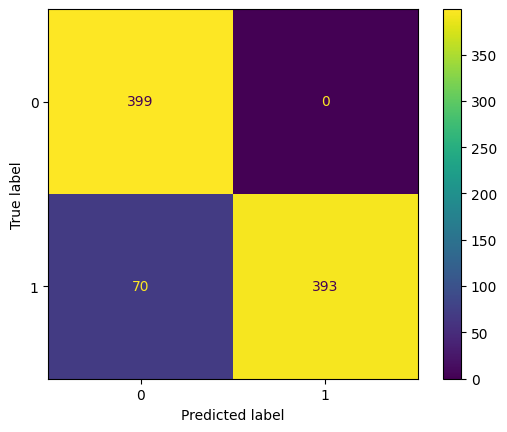

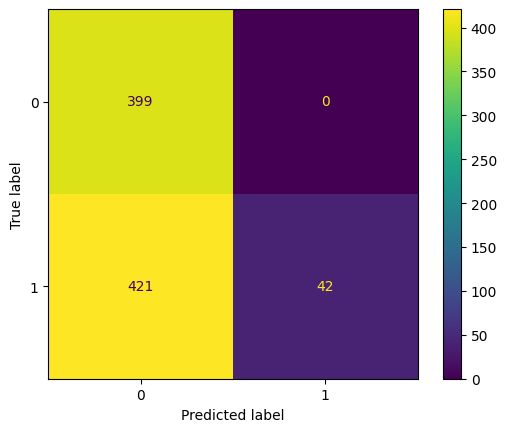

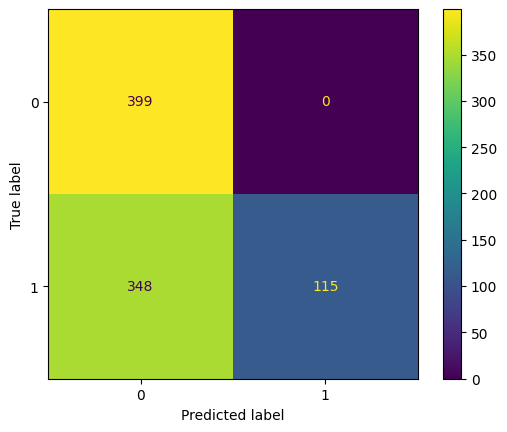

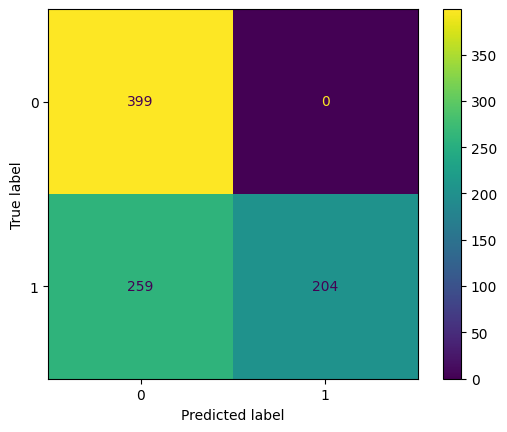

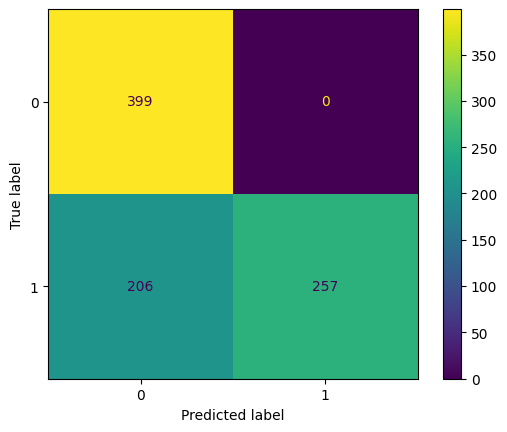

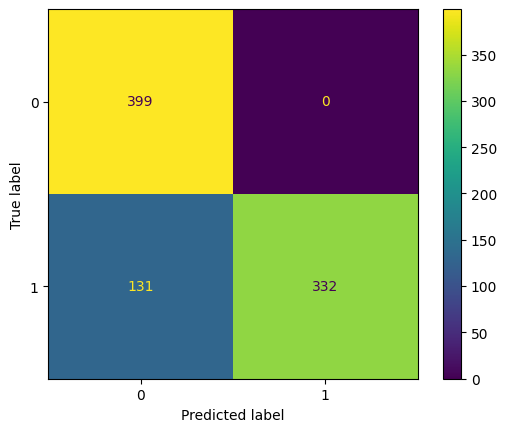

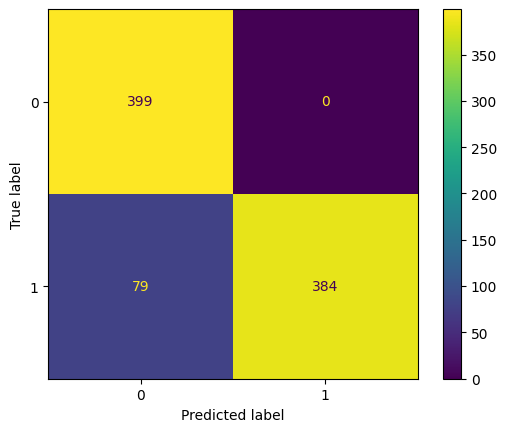

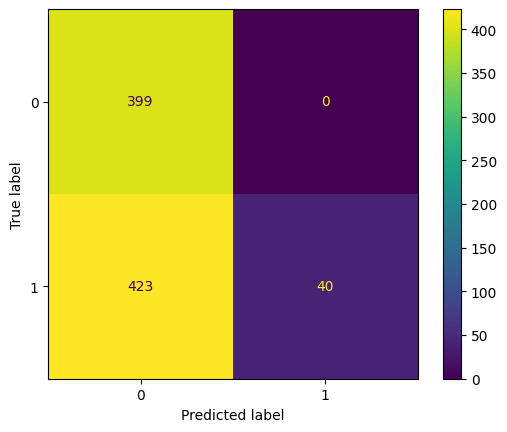

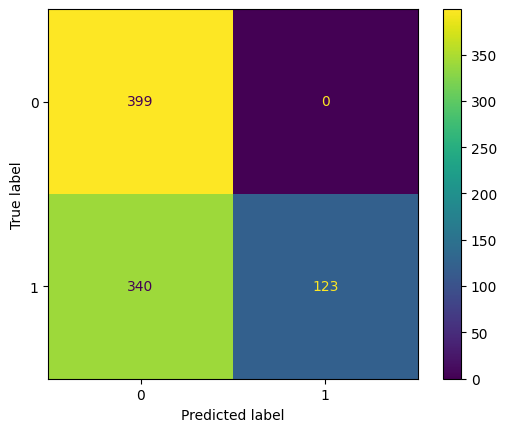

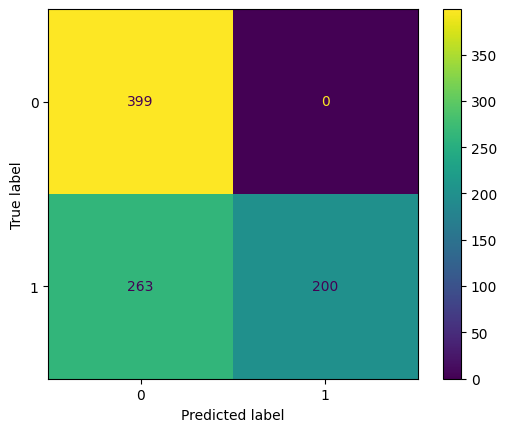

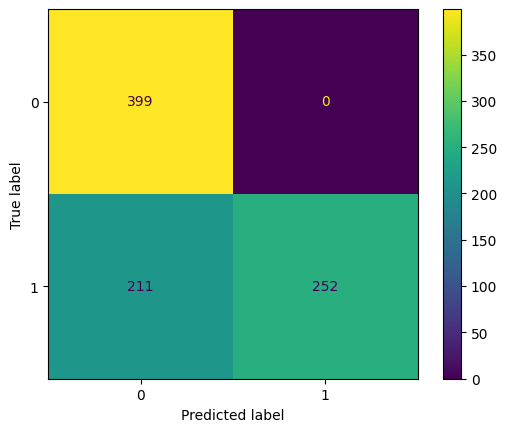

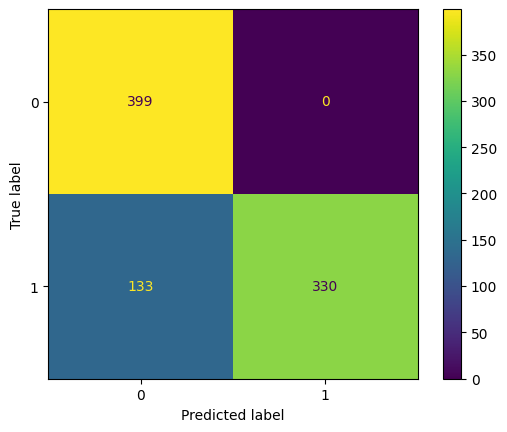

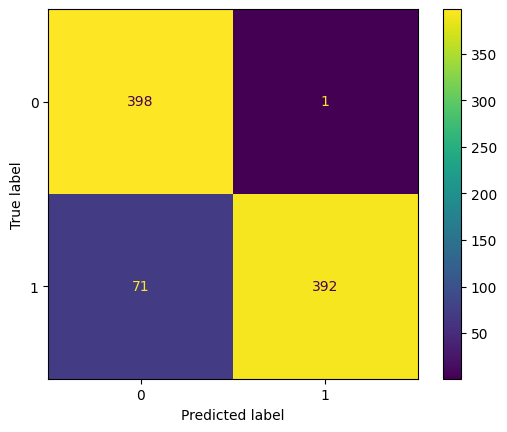

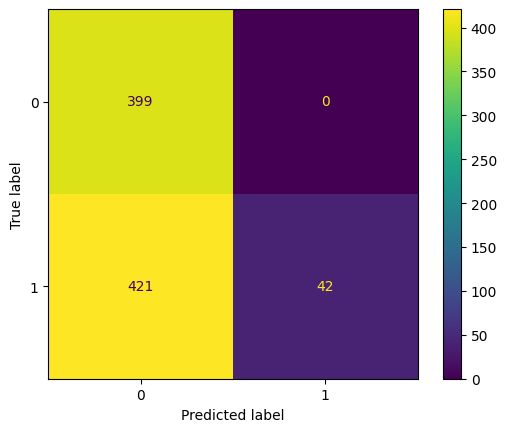

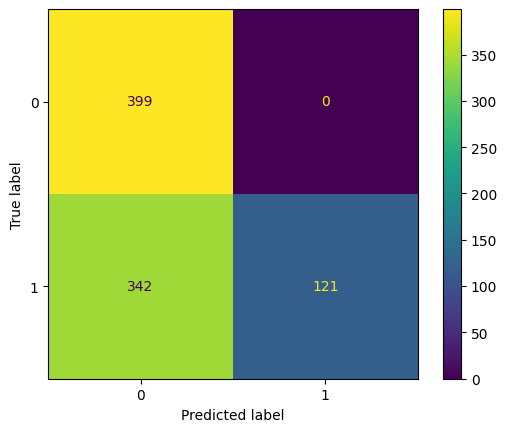

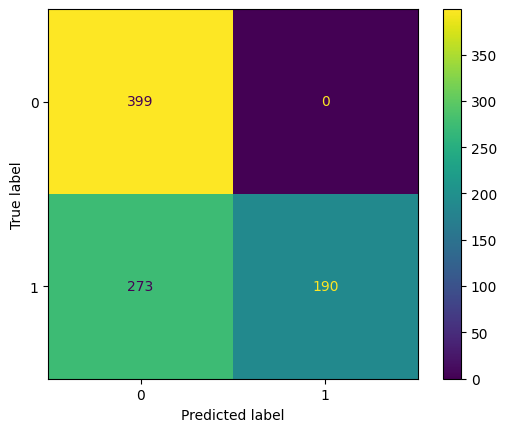

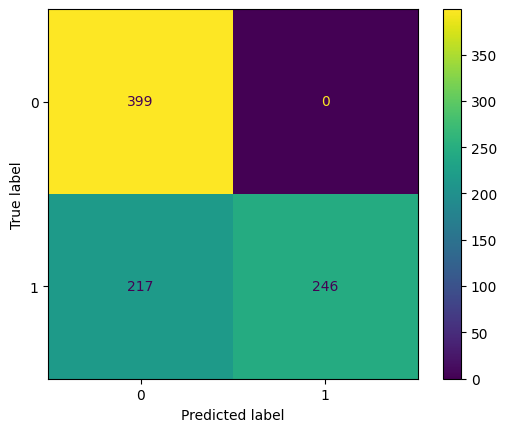

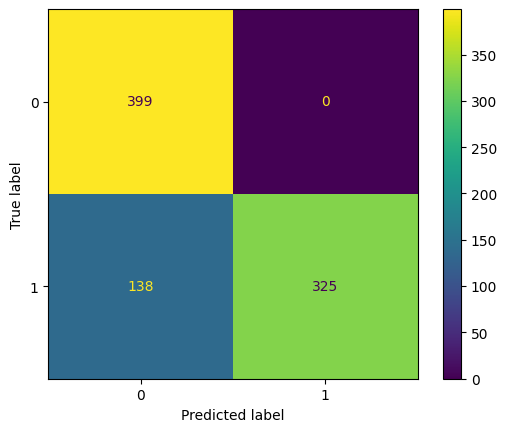

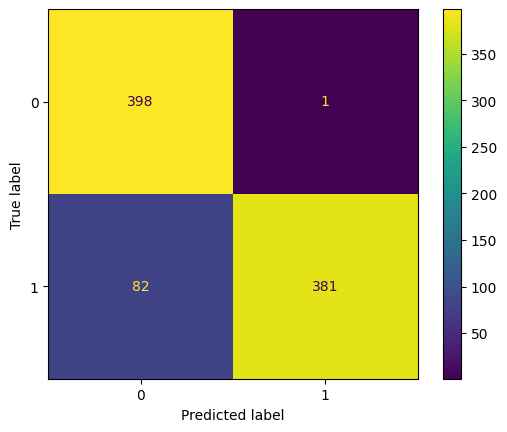

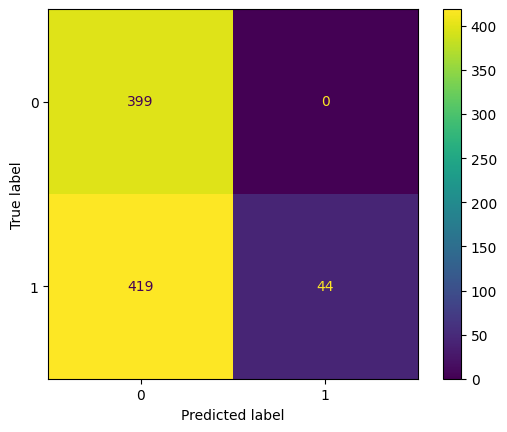

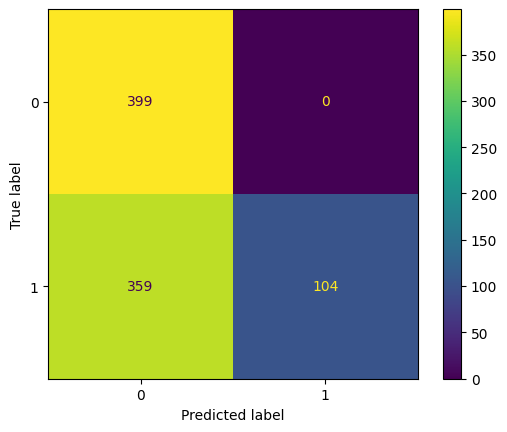

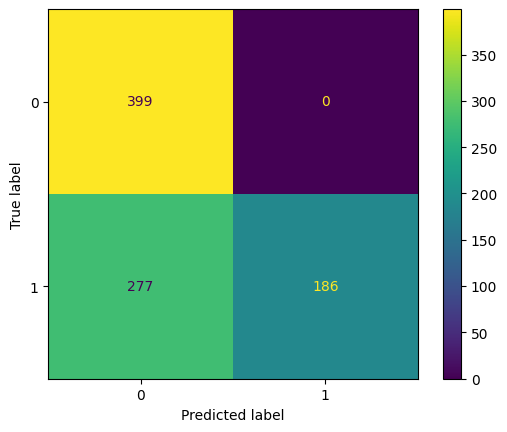

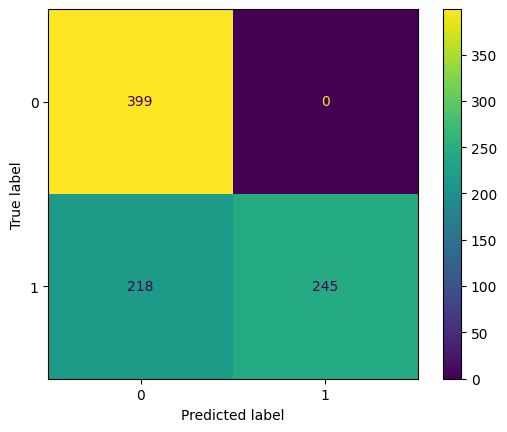

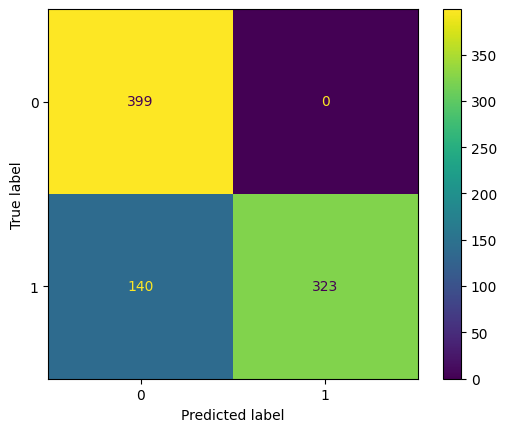

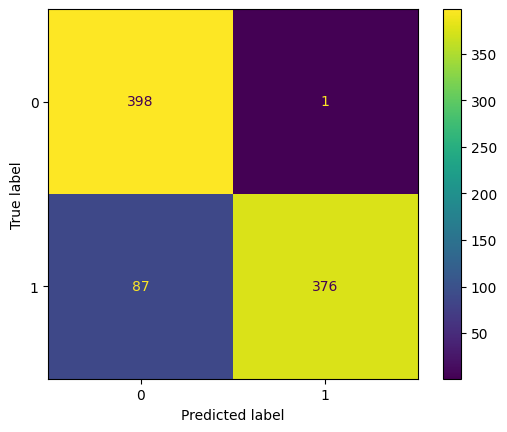

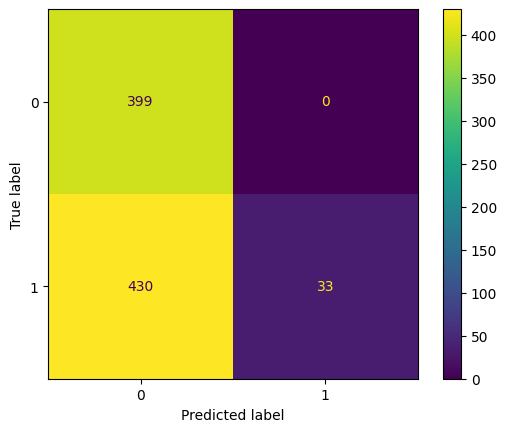

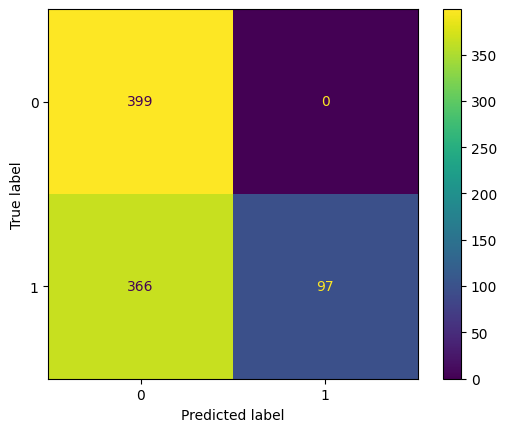

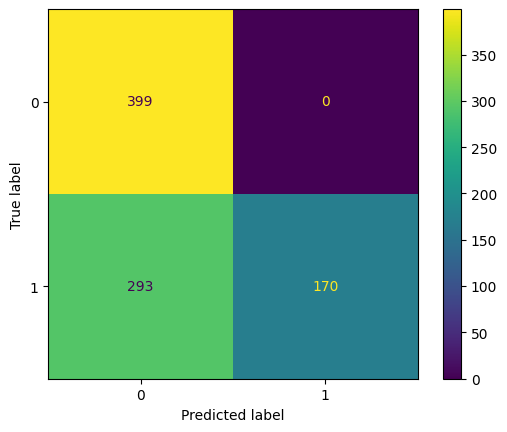

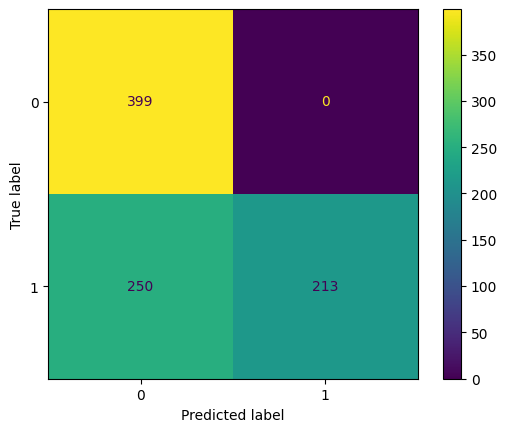

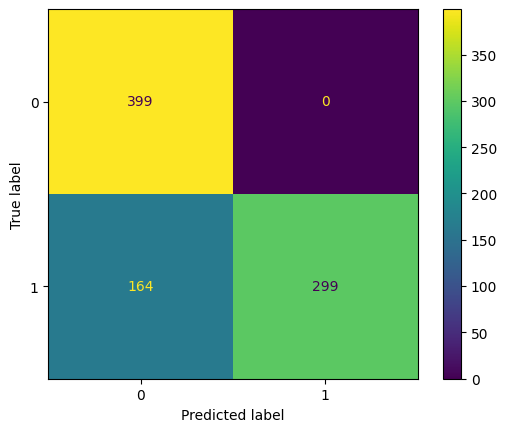

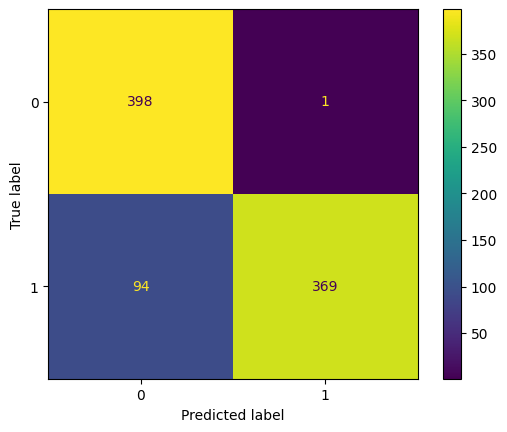

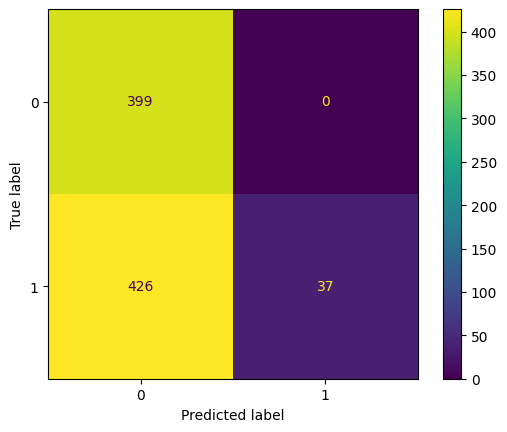

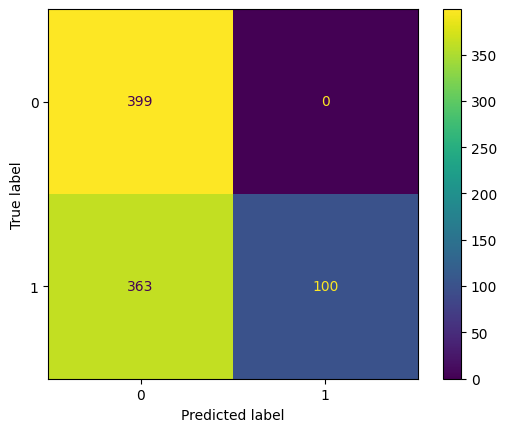

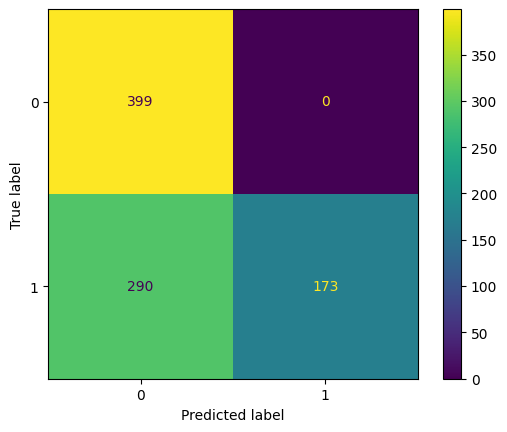

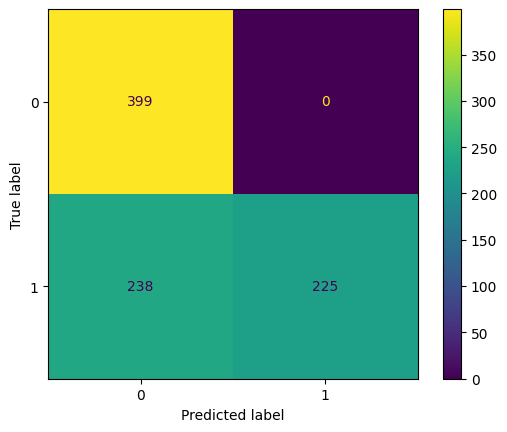

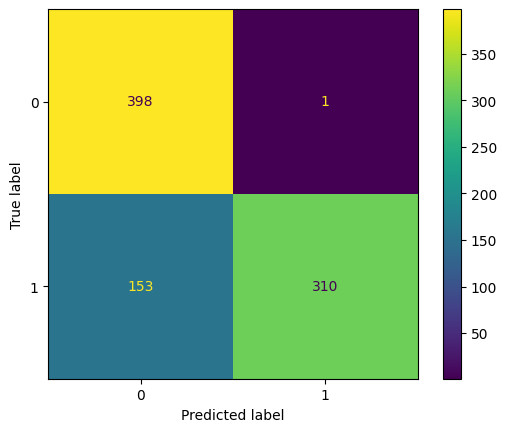

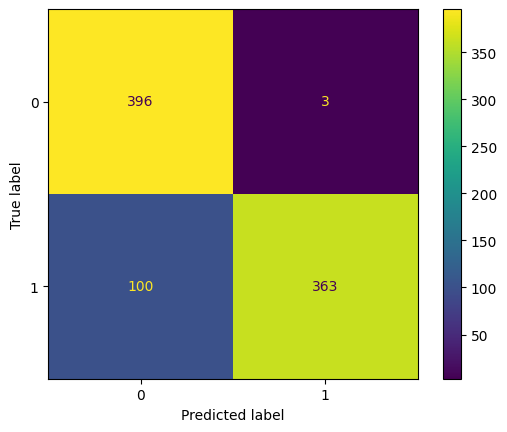

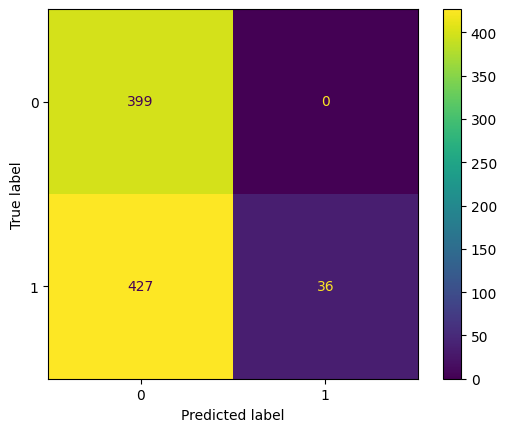

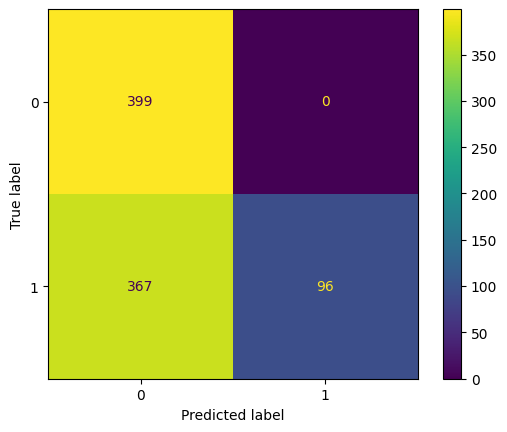

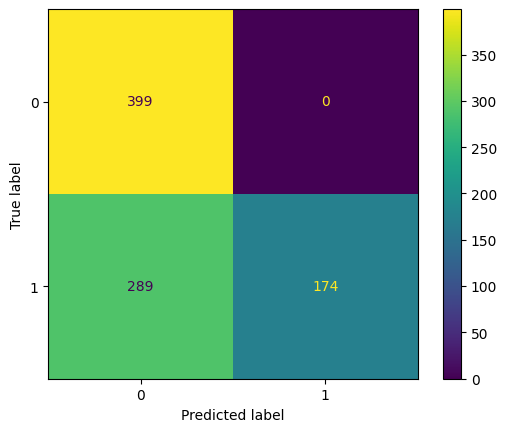

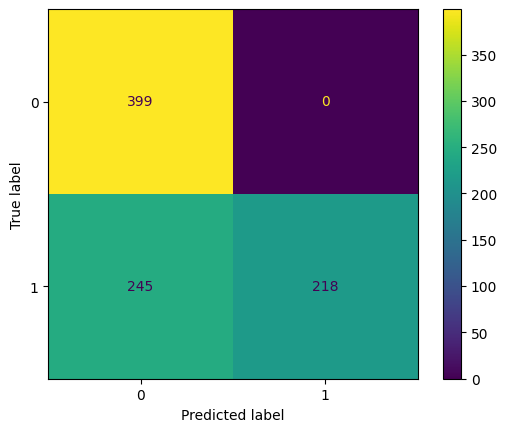

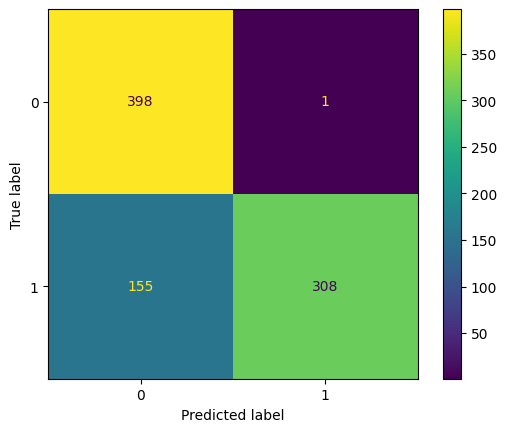

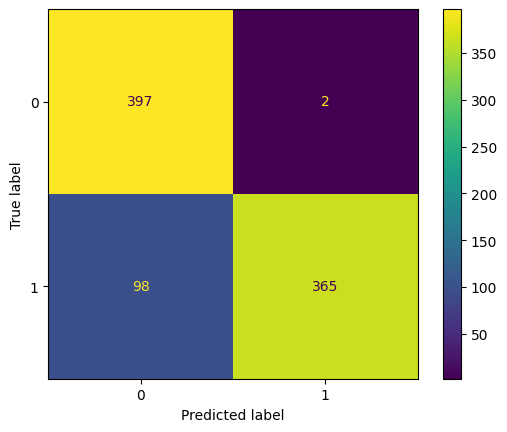

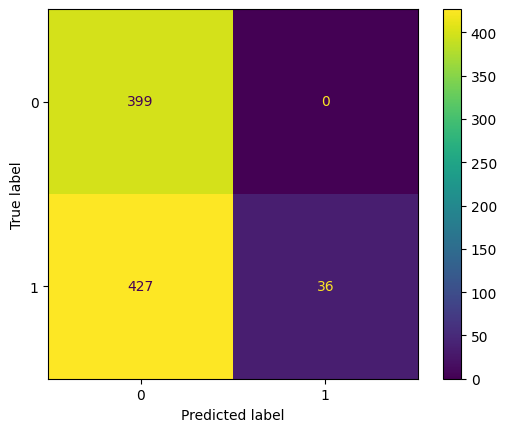

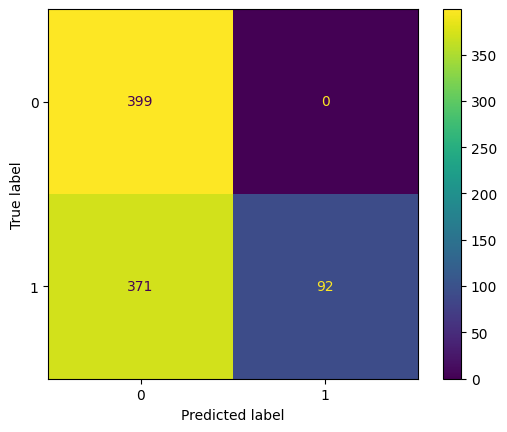

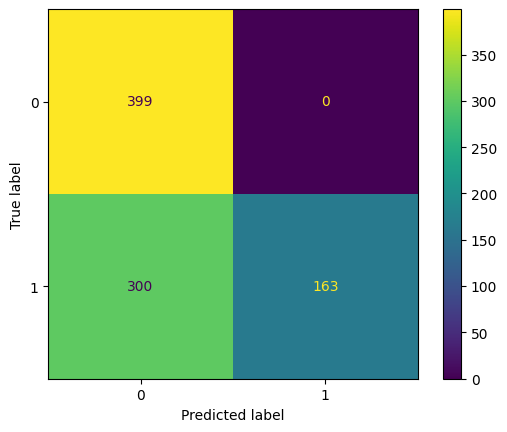

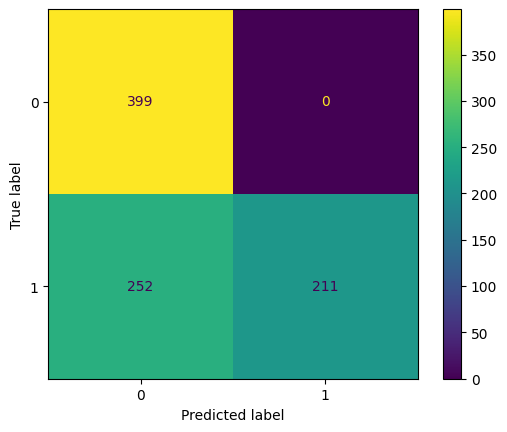

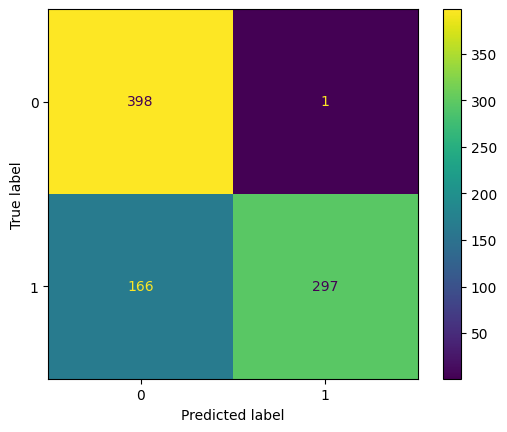

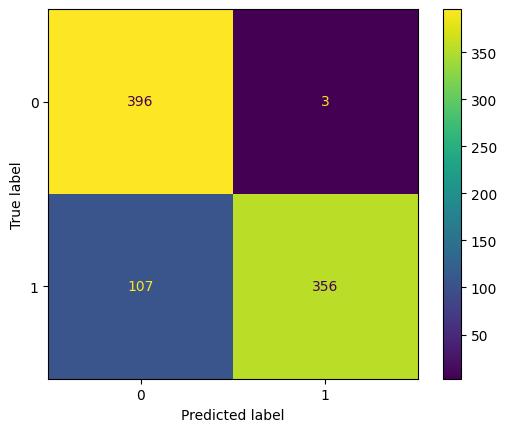

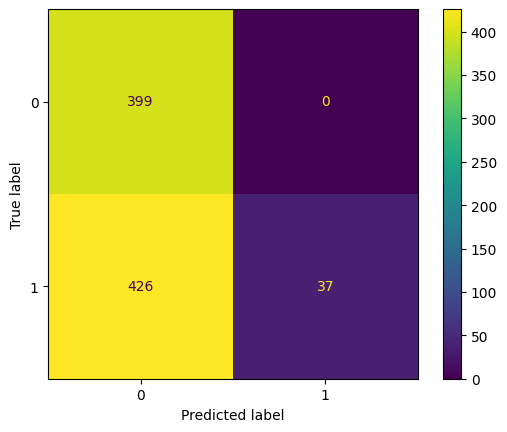

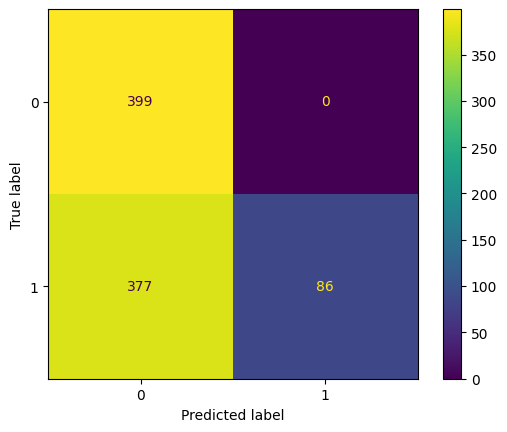

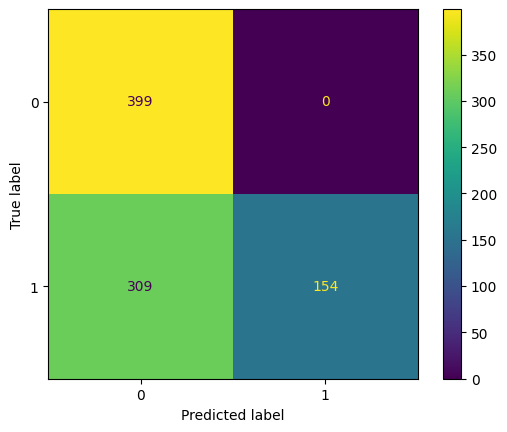

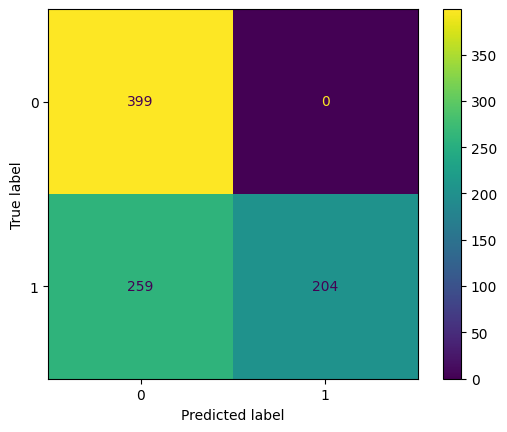

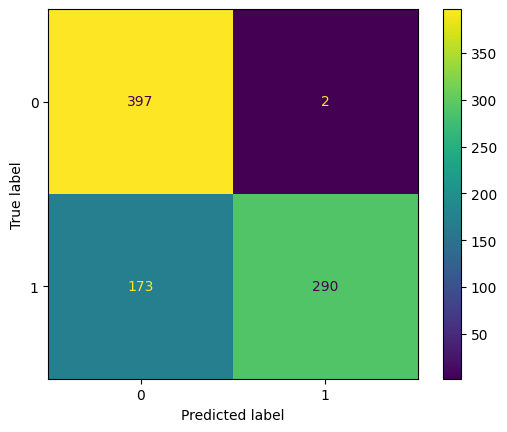

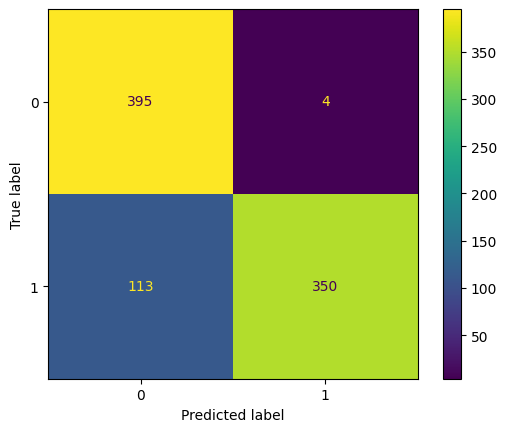

In [ ]:
cont = ['auto',0.01,0.05,0.1,0.25,0.5]
neig = [2,5,10,20,30]
met = ["cityblock","minkowski"]
i = 31

for m in met:
    for n in neig:
        for c in cont:
            
            run_name = 'MC_LOF_run_novelty_'+ str(i) + "'"
            
            params = {
                    "novelty":True,
                    "n_neighbors":n,
                    "contamination":c,
                    "metric":m,
                    "n_jobs":-1,
                    }


            with mlflow.start_run(run_name=run_name, nested=False,  tags={"project": "Anomalie_classification", "model": "LOF","Data":"DATASET_GO_NG.csv without nan"}) as run :
                
                # Instanciation de l'algo LOF de base
                model = LocalOutlierFactor(**params)
                
                # Training sans réduction de dimension
                model.fit(X_scaled)

                # Prédiction sur l'ensemble de training
                #y_pred = model.predict(X_scaled)
                #y_pred[y_pred == 1] = 0
                #y_pred[y_pred == -1] = 1
                
                # Vision de la classification
                #df_pred = pd.DataFrame({"y_pred":y_pred})
                #print("Vision inliers_outliers sur données de test \n",df_pred.y_pred.value_counts(normalize=True))
                
                #training_inliers = 100 * df_pred.y_pred.value_counts(normalize=True)[0]
                #training_outliers = 100 * df_pred.y_pred.value_counts(normalize=True)[1]
                
                # Inférence du modèle sur les données de validation provenant du dataset_validation (concaténation défauts/sans défauts)
                y_inf = model.predict(X_val_scaled)
                y_inf[y_inf == 1] = 0 # on remplace la valeur des inliers par 0
                y_inf[y_inf == -1] = 1 # on remplace la valeur des outliers par 1
                
                # Visualisation des métriques
                n_errors = (y_inf!=y_val.values).sum()
                print("Nombre d'erreurs : ",n_errors,"\n")
                
                accuracy = 100*accuracy_score(y_val.values,y_inf)
                print(f'Accuracy : {accuracy:.2f} %',"\n")
                
                # affichage du ROC-AUC score
                rocauc_score = 100 * roc_auc_score(y_val,y_inf)
                print(f'Score ROC-AUC : {rocauc_score:.2f} %',"\n")

                # affichage du MCC score
                mcc_score = matthews_corrcoef(y_val,y_inf)
                print(f'Score MCC : {mcc_score}',"\n")

                print("Rapport de classification : \n",classification_report(y_val.values,y_inf),"\n")

                precision = 100 * precision_score(y_val.values,y_inf)
                recall = 100 * recall_score(y_val.values,y_inf)
                f1score = 100 * f1_score(y_val.values,y_inf)


                cm = confusion_matrix(y_val.values, y_pred=y_inf)

                FN_rate = 100 * (cm[1][0] / (cm[1][0]+cm[1][1]))
                FP_rate = 100 * (cm[0][1] / (cm[0][1]+cm[0][0]))
                Sensibility = 100 * (cm[1][1] / (cm[1][1]+cm[1][0]))
                Specificity = 100 * (cm[0][0] / (cm[0][0]+cm[0][1]))


                matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
                print("Matrice de confusion : \n")
                figure = matrix.plot()
                
                metrics ={  #"dataset_detected_inliers":training_inliers,
                            #"dataset_detected_outliers":training_outliers,
                            "nb_erreurs_prediction":n_errors,
                            "Accuracy":accuracy,
                            "Score ROC-AUC":rocauc_score,
                            "Score MCC":mcc_score,
                            "Recall":recall,
                            "F1-score":f1score,
                            "Sensibility":Sensibility,
                            "Specificity":Specificity,
                            "Precision":precision,
                            "FN_rate":FN_rate,
                            "FP_rate":FP_rate}
                
                mlflow.log_params(params)
                mlflow.log_metrics(metrics)
                #mlflow.log_figure(figure, "Confusion_Matrix.png")
                mlflow.sklearn.log_model(sk_model=model,input_example=X_val_scaled,artifact_path=artifact_path)
            
            i +=1